<hr>
<font size=5 color='#543ba3'> <b> Programowanie dla analityki danych projekt cz.1 - czyszczenie danych </b> </font> 
<hr/>

Na podstawie danych w pliku messy_data.csv przygotuj interaktywny dashboard do analizy danych.
Etapy pracy domowej:
* wstępna analiza danych i czyszczenie:
  - duplikaty
  - wartości odstające
  - spójność
  - braki w danych
  - skala wartości
  - inne
* wizualizacja rozkładu zmiennych, zależności ceny od innych zmiennych, liczebność kategorii
* budowa modelu regresji ceny od pozostałych zmiennych. Istotne zmienne należy wybrać eliminacją wsteczną lub selekcją postępującą.

* wizualizacja modelu regresji
* stworzenie dashboardu z powyższymi wizualizacjami i próbką danych w postaci tabeli. Dashboard powinien umożliwiać zmianę parametrów wykresów - np. zależność ceny od innej, wybranej przez użytkownika zmiennej

## Biblioteki

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

warnings.simplefilter(action='ignore', category=FutureWarning)

## Dane
Dane wczytujemy z opccją ```skipinitialspace=True```, które automatycznie usunie wiodącą spację.

In [2]:
df = pd.read_csv('messy_data.csv', skipinitialspace=True)

In [3]:
df.head()

,carat,clarity,color,cut,x dimension,y dimension,z dimension,depth,table,price
0,0.5,IF,D,Ideal,5.1,5.15,3.20,61.5,NaN,3000.0
1,0.7,vvs2,E,premium,5.7,NaN,3.52,62.0,59.0,4500.0
2,NaN,Si2,h,Good,4.3,4.31,NaN,62.3,56.0,700.0
3,1.2,if,d,ideal,NaN,6.82,4.20,61.7,58.0,10000.0
4,0.9,I1,J,Fair,6.0,NaN,3.70,61.7,NaN,2400.0


Kolumny:
* ```carat```: Wartości liczbowe reprezentujące wagę diamentu.
* ```clarity```: Dane tekstowe wskazujące stopień przejrzystości diamentu (np. IF, vvs2, Si2, I1).
* ```color```: dane tekstowe przedstawiające kolor diamentu (np. D, E, H, J).
* ```cut```: Dane tekstowe opisujące szlif diamentu (np. Idealny, Premium, Dobry, Dostateczny).
* ```x dimension```, ```y dimension```, ```z dimension```: Wartości liczbowe prawdopodobnie reprezentujące wymiary diamentu.
* ```depth```: Wartości numeryczne wskazujące głębokość diamentu.
* ```table```: Wartości liczbowe reprezentujące wielkość tafli w procentach w odniesieniu do całkowitej średnicy kamienia.
* ```price```: Wartości liczbowe reprezentujące cenę diamentu.

In [4]:
df.shape

(200, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   carat        150 non-null    float64
 1   clarity      200 non-null    object 
 2   color        200 non-null    object 
 3   cut          200 non-null    object 
 4   x dimension  197 non-null    float64
 5   y dimension  136 non-null    float64
 6   z dimension  152 non-null    float64
 7   depth        133 non-null    float64
 8   table        167 non-null    float64
 9   price        196 non-null    float64
dtypes: float64(7), object(3)
memory usage: 15.8+ KB


In [6]:
df.describe()

,carat,x dimension,y dimension,z dimension,depth,table,price
count,150.000000,197.000000,136.000000,152.000000,133.000000,167.000000,196.000000
mean,0.799000,5.885787,5.829706,3.694671,62.316541,56.910180,11410.714286
std,0.321827,0.770172,0.767402,0.462431,0.326408,1.421972,40072.669086
min,0.200000,3.900000,3.890000,2.410000,61.200000,54.000000,500.000000
25%,0.512500,5.300000,5.290000,3.350000,62.100000,56.000000,2600.000000
50%,0.750000,5.900000,5.850000,3.715000,62.300000,57.000000,4350.000000
75%,1.050000,6.500000,6.512500,4.082500,62.600000,58.000000,7900.000000
max,1.600000,7.300000,7.280000,4.500000,63.000000,60.000000,350000.000000


In [7]:
df.isna().sum()

carat          50
clarity         0
color           0
cut             0
x dimension     3
y dimension    64
z dimension    48
depth          67
table          33
price           4
dtype: int64

In [8]:
print('Procent brakujących wartości:')
df.apply(lambda col: col.isna().sum()/len(df))

Procent brakujących wartości:


carat          0.250
clarity        0.000
color          0.000
cut            0.000
x dimension    0.015
y dimension    0.320
z dimension    0.240
depth          0.335
table          0.165
price          0.020
dtype: float64

Widzimy, że brakujące wartości są we wszystkich zmiennych numerycznych.

In [9]:
df.dtypes

carat          float64
clarity         object
color           object
cut             object
x dimension    float64
y dimension    float64
z dimension    float64
depth          float64
table          float64
price          float64
dtype: object

## Przygotowanie danych

In [10]:
df.columns = df.columns.str.replace(' ', '_')

In [11]:
df[df.duplicated(subset=['x_dimension', 'y_dimension', 'z_dimension', 'depth', 'table'], keep=False)]

,carat,clarity,color,cut,x_dimension,y_dimension,z_dimension,depth,table,price
143,NaN,IF,I,Premium,6.5,6.52,4.03,62.6,NaN,7700.0
185,NaN,VVS1,H,Good,6.5,6.52,4.03,62.6,NaN,7900.0


In [12]:
# zmienne kategoryczne
cat_vars = ['cut', 'color', 'clarity']

In [13]:
for c in cat_vars:
    print(f'-------- {c} -------')
    print(df[c].value_counts())
    print()

-------- cut -------
cut
Premium      34
Good         30
fair         24
Ideal        23
good         21
very good    19
Fair         12
Very good    10
ideal         9
Very Good     9
premium       7
very Good     2
Name: count, dtype: int64

-------- color -------
color
G            36
I            33
H            30
F            24
D            13
E            13
e            12
d             9
f             6
j             6
colorless     6
h             4
g             4
J             2
Colorless     2
Name: count, dtype: int64

-------- clarity -------
clarity
i1      26
si2     23
VVS1    23
IF      20
VVS2    19
vvs2    18
si1     18
Si2     16
Si1     12
vvs1    11
I1       5
SI2      5
if       3
Vvs1     1
Name: count, dtype: int64



Widzimy, że te same nazwy są zapisane wieloma sposobami.

In [14]:
df[cat_vars] = df[cat_vars].apply(lambda c: c.str.lower())

In [15]:
for c in cat_vars:
    print(f'-------- {c} -------')
    print(df[c].value_counts())
    print()

-------- cut -------
cut
good         51
premium      41
very good    40
fair         36
ideal        32
Name: count, dtype: int64

-------- color -------
color
g            40
h            34
i            33
f            30
e            25
d            22
j             8
colorless     8
Name: count, dtype: int64

-------- clarity -------
clarity
si2     44
vvs2    37
vvs1    35
i1      31
si1     30
if      23
Name: count, dtype: int64



### Uzupełnienie brakujących obserwacji

#### Mediana

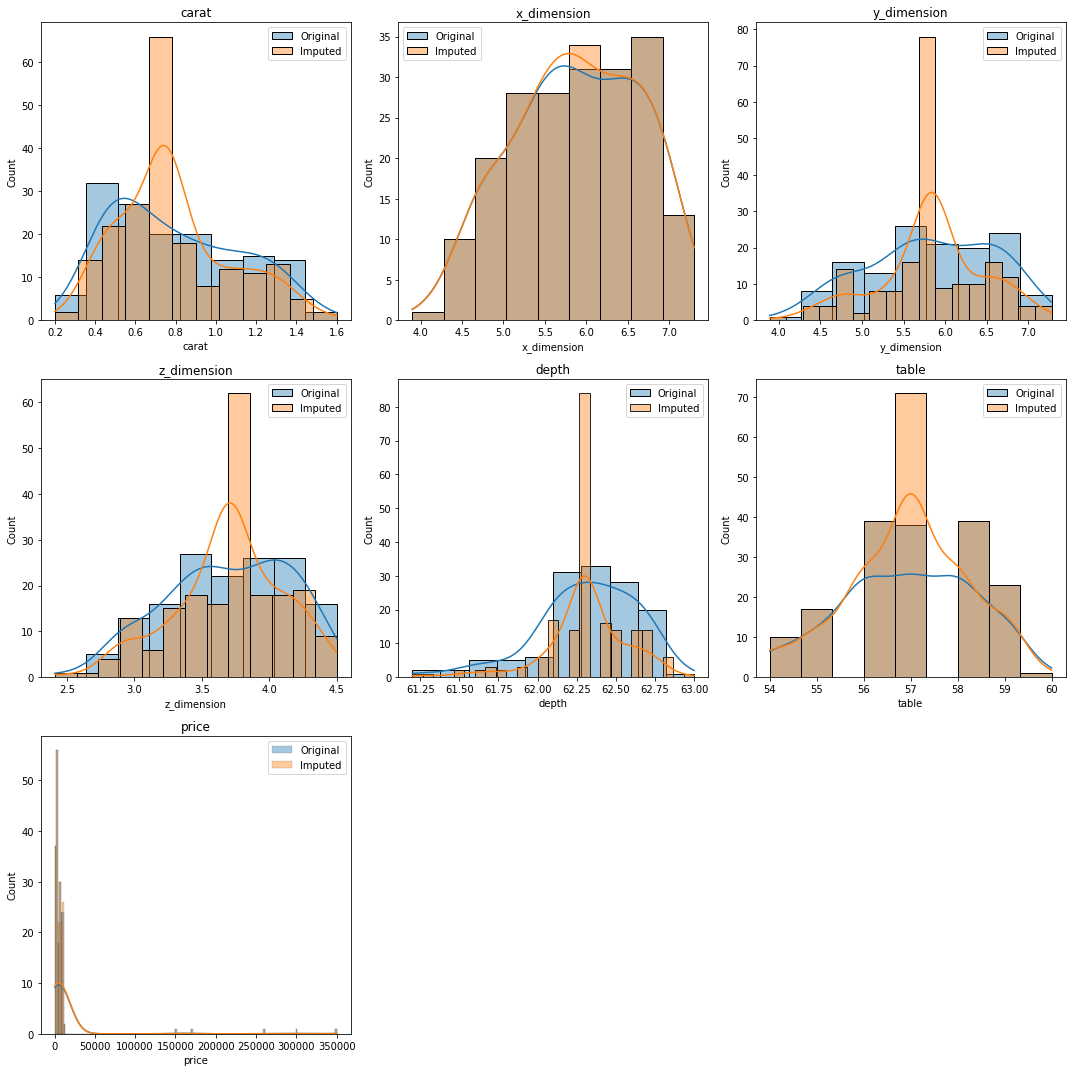

In [16]:
original_data = df.copy()

numeric_columns = ['carat', 'x_dimension', 'y_dimension', 'z_dimension', 'depth', 'table', 'price']

imputer = SimpleImputer(strategy='median')
data_imputed = pd.DataFrame(imputer.fit_transform(original_data[numeric_columns]), 
                            columns=numeric_columns)

data_imputed = pd.concat([data_imputed, original_data.drop(numeric_columns, axis=1).reset_index(drop=True)], axis=1)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(original_data[col], ax=axes[i], label='Original', kde=True, alpha=0.4)
    sns.histplot(data_imputed[col], ax=axes[i], label='Imputed', kde=True, alpha=0.4)
    axes[i].set_title(col)
    axes[i].legend()

fig.delaxes(axes[-1])
fig.delaxes(axes[-2])
plt.tight_layout()
plt.show()

#### IterativeImputer

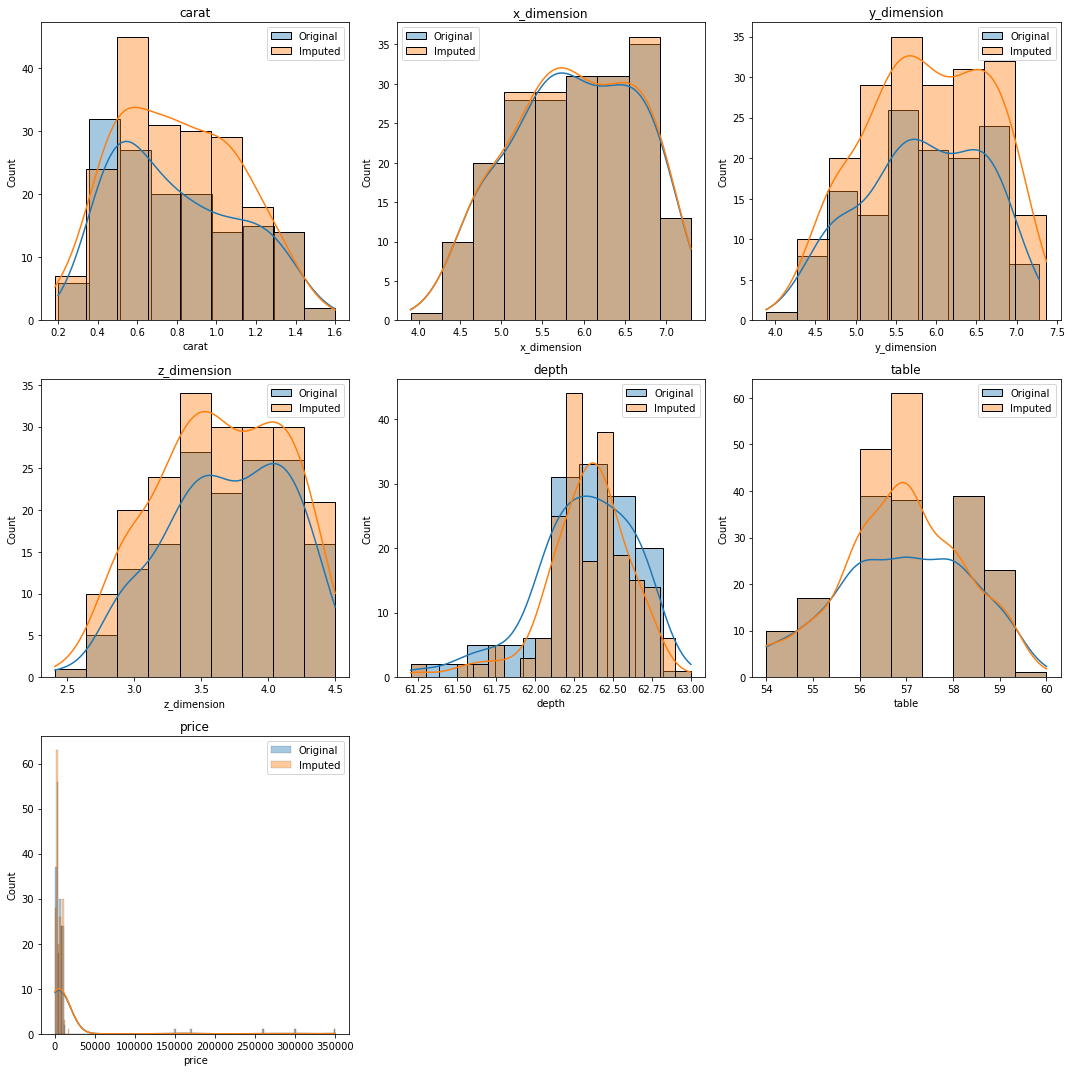

In [17]:
iterative_imputer = IterativeImputer(max_iter=10, random_state=0)
data_imputed = pd.DataFrame(iterative_imputer.fit_transform(original_data[numeric_columns]), 
                            columns=numeric_columns)

data_imputed = pd.concat([data_imputed, original_data.drop(numeric_columns, axis=1).reset_index(drop=True)], axis=1)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(original_data[col], ax=axes[i], label='Original', kde=True, alpha=0.4)
    sns.histplot(data_imputed[col], ax=axes[i], label='Imputed', kde=True, alpha=0.4)
    axes[i].set_title(col)
    axes[i].legend()

fig.delaxes(axes[-1])
fig.delaxes(axes[-2])
plt.tight_layout()
plt.show()

W tym przypadku rozkłady są bardziej zbliżone do oryginalnych.

### Wartości odstające

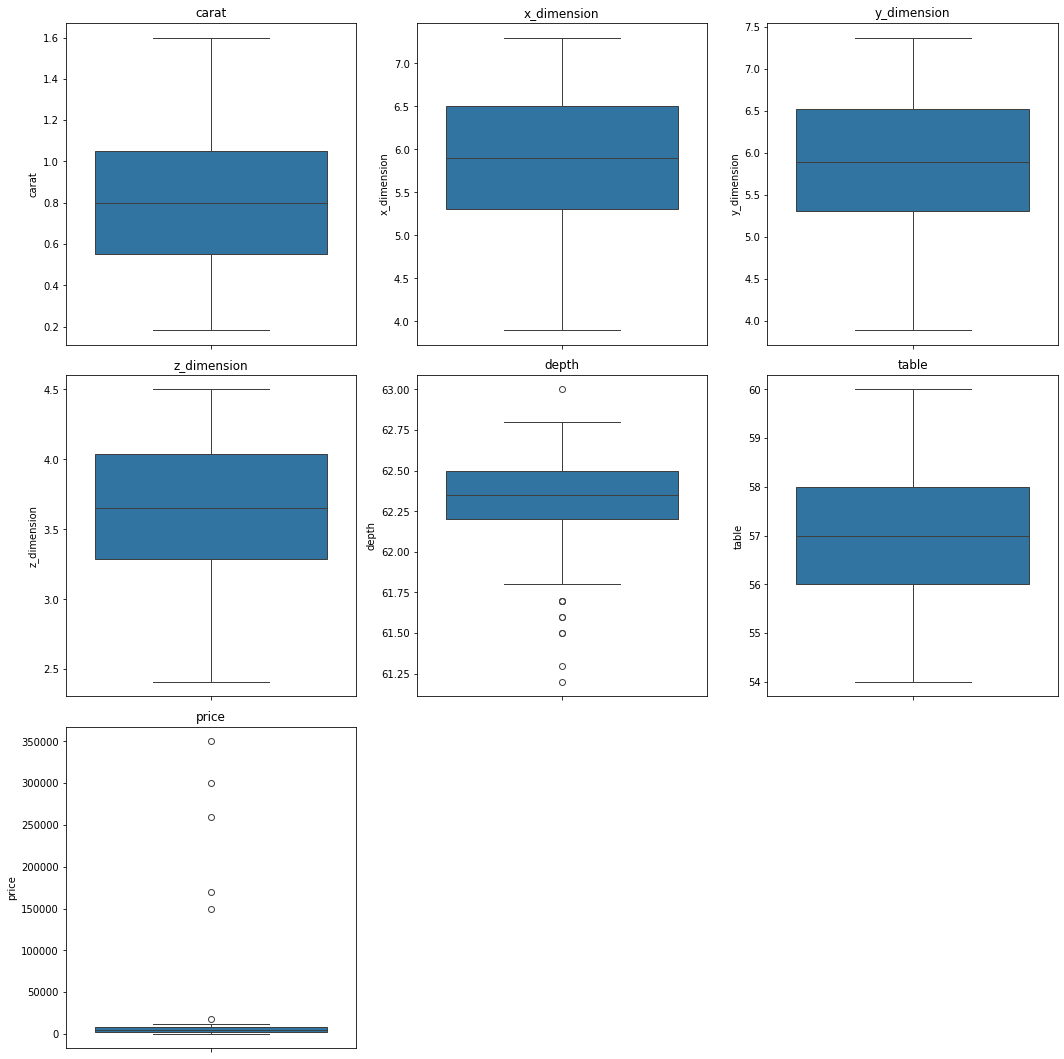

In [18]:
# Boxplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()
for i, col in enumerate(numeric_columns):
    sns.boxplot(y=data_imputed[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
fig.delaxes(axes[-1])
fig.delaxes(axes[-2])

In [19]:
# Detect outliers using the IQR method
def detect_outliers(df, features):
    outlier_indices = []
    outlier_feature = {}

    for c in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[c], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[c], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR

        # List of indices of outliers for feature c
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
        outlier_feature[c] = outlier_list_col

    outlier_indices = list(set(outlier_indices))
    return outlier_indices, outlier_feature

outliers, outlier_feature = detect_outliers(data_imputed, numeric_columns)

print('Number of Outliers', len(outliers)),
print('Percentage of Dataset', len(outliers) / len(data_imputed) * 100)
print(outlier_feature)

Number of Outliers 15
Percentage of Dataset 7.5
{'carat': Index([], dtype='int64'), 'x_dimension': Index([], dtype='int64'), 'y_dimension': Index([], dtype='int64'), 'z_dimension': Index([], dtype='int64'), 'depth': Index([0, 3, 4, 6, 10, 11, 15, 17, 19, 21], dtype='int64'), 'table': Index([], dtype='int64'), 'price': Index([17, 182, 184, 187, 189, 197], dtype='int64')}


Wartości odstające znajdują się w kolumnach ```price``` i ```depth```.

In [20]:
data_imputed.iloc[outliers]

,carat,x_dimension,y_dimension,z_dimension,depth,table,price,clarity,color,cut
0,0.500000,5.100000,5.150000,3.200000,61.500000,56.637089,3000.000000,if,d,ideal
3,1.200000,6.802001,6.820000,4.200000,61.700000,58.000000,10000.000000,if,d,ideal
4,0.900000,6.000000,5.997816,3.700000,61.700000,56.969121,2400.000000,i1,j,fair
197,0.550000,5.300000,5.326153,3.280000,62.300000,57.000000,150000.000000,i1,i,premium
6,0.500000,5.100000,5.135399,3.200000,61.500000,57.000000,3100.000000,if,d,ideal
10,0.500000,5.199509,5.210000,3.210000,61.600000,58.000000,11102.189775,si1,colorless,premium
11,0.400000,4.900000,4.880000,3.025613,61.200000,56.000000,1400.000000,vvs2,g,very good
15,0.199499,4.400000,4.390000,2.690000,61.300000,57.000000,3488.829418,vvs2,i,good
17,1.000000,6.500000,6.490000,4.013331,61.700000,58.000000,18361.965283,if,d,ideal
19,0.700000,5.784256,5.790000,3.570000,61.600000,56.886207,2100.000000,i1,j,fair


In [21]:
data_imputed.iloc[outlier_feature['price']]['price']

17      18361.965283
182    170000.000000
184    350000.000000
187    260000.000000
189    300000.000000
197    150000.000000
Name: price, dtype: float64

Analizując wartości odstające, te w kolumnie ```depth``` nie wydają się bardzo znaczące. W kolumnie ```price``` mamy natomiast kilka bardzo dużych wartości (powyżej 100k), które wydają się mało prawdopodobne uwzględniając ilość karatów, wymiary diamentu i szlif. Tak mocno odstające obserwacje znacząco wpływają na prostą regresji. Ponieważ są tylko 4 takie obserwacje, usuniemy je ze zbioru. Poza usunięciem tych obserwacji, stosowanie dodatkowych metod, takich jak capping nie wydaje się uzasadnione.

In [22]:
data_trimmed = data_imputed.copy()
data_trimmed = data_trimmed[data_trimmed['price'] < 100000]

<Axes: xlabel='price', ylabel='Count'>

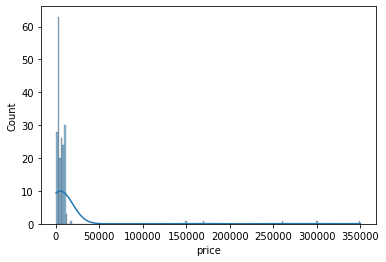

In [23]:
sns.histplot(data=data_imputed, x='price', kde=True)

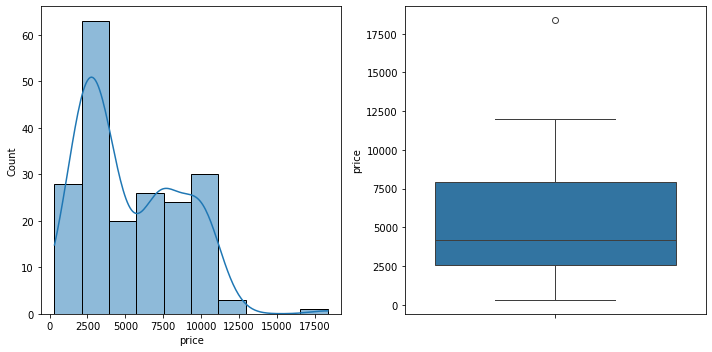

In [24]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(data=data_trimmed, x='price', kde=True)
plt.subplot(1,2,2)
sns.boxplot(data=data_trimmed, y='price')
plt.tight_layout()

In [25]:
data_trimmed.to_csv('clean_data.csv', index=False)

In [26]:
data_trimmed.shape

(195, 10)

## Wizualizacje

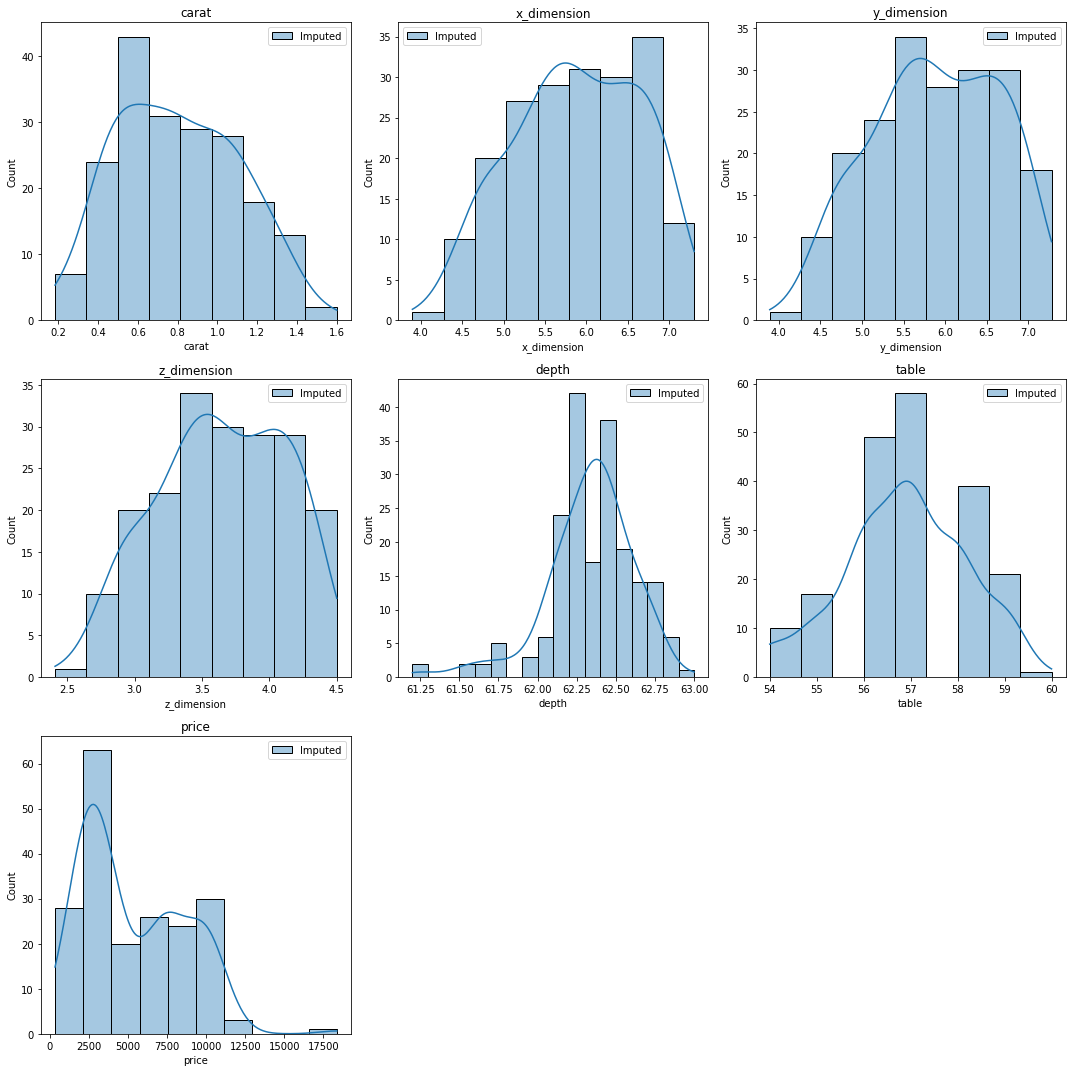

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(data_trimmed[col], ax=axes[i], label='Imputed', kde=True, alpha=0.4)
    axes[i].set_title(col)
    axes[i].legend()

fig.delaxes(axes[-1])
fig.delaxes(axes[-2])
plt.tight_layout()
plt.show()

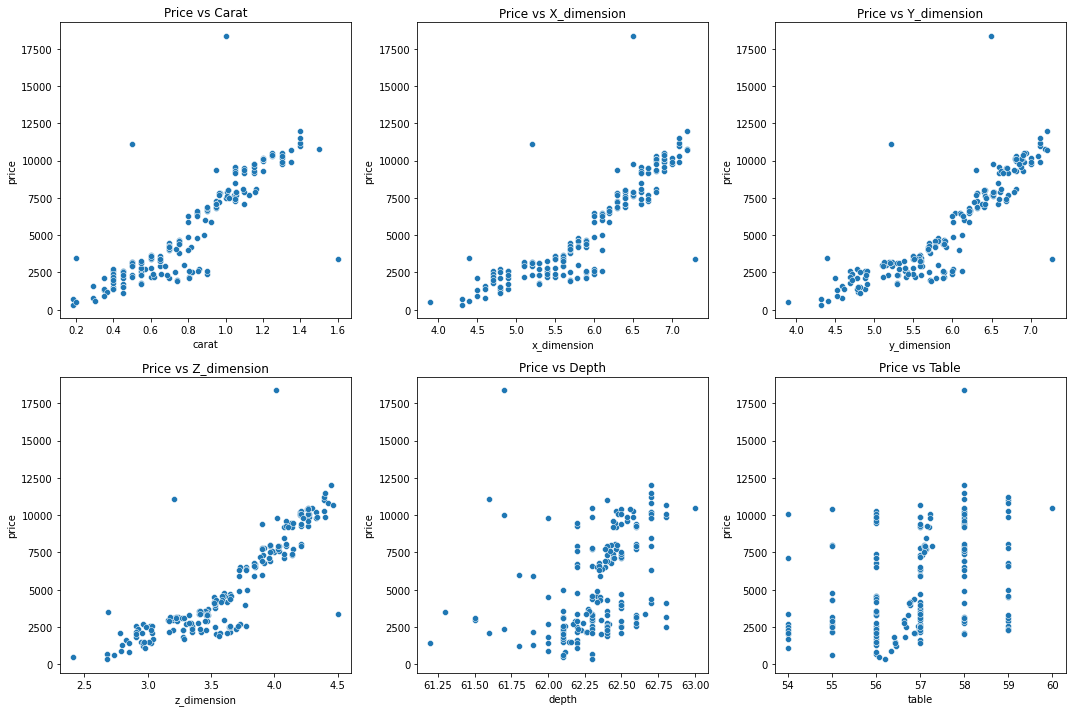

In [29]:
# Plotting price variable against other numeric variables
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()
numeric_columns_except_price = [col for col in numeric_columns if col != 'price']

for i, col in enumerate(numeric_columns_except_price):
    sns.scatterplot(x=col, y='price', data=data_trimmed, ax=axes[i])
    axes[i].set_title(f'Price vs {col.capitalize()}')

plt.tight_layout()
plt.show()

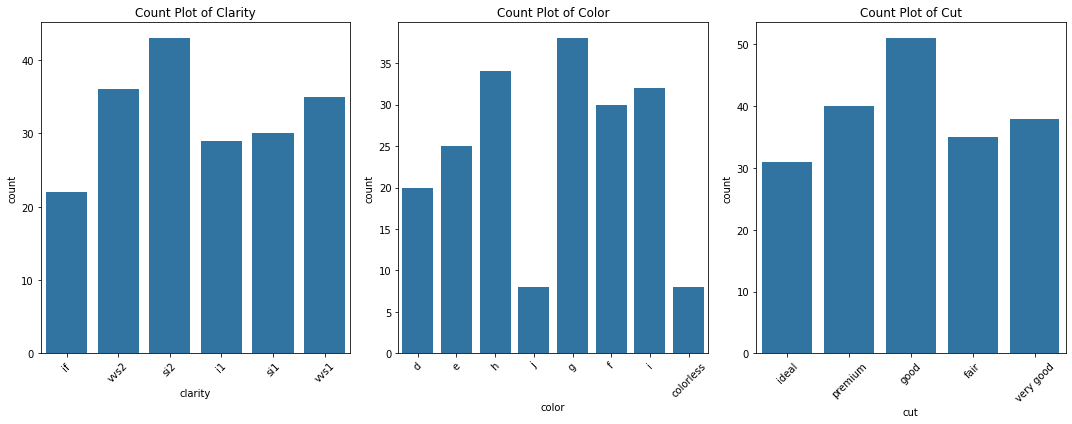

In [30]:
# Plotting count plots for categorical variables
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
categorical_columns = ['clarity', 'color', 'cut']

for i, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=data_trimmed, ax=axes[i])
    axes[i].set_title(f'Count Plot of {col.capitalize()}')
    for label in axes[i].get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

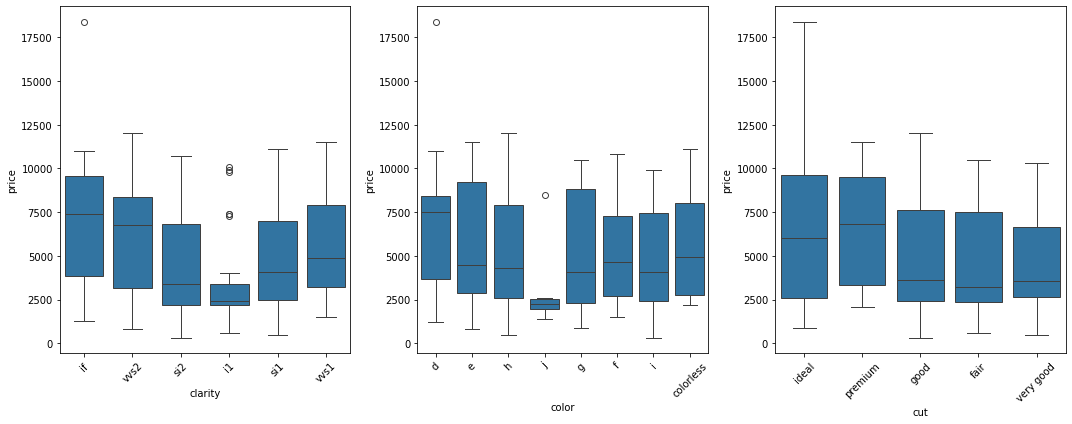

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

for i, col in enumerate(categorical_columns):
    sns.boxplot(x=col, y='price', data=data_trimmed, ax=axes[i])
    for label in axes[i].get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()